In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot
import sklearn.linear_model
import matplotlib.pyplot as plt
import pyreadstat
import datetime
import FG_Methods_1
import tabulate
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import openpyxl
import copy

def return_all_column_names_beginning_with_prefix(column_names, prefix):    
    col_list = []
    for col_name in column_names:
        if col_name.find(prefix) == 0:
            col_list = col_list + [col_name]
    return col_list


Parameters, Data Download and Data Prep Stage 1

In [2]:
"""General Parameters"""

prefixs_to_study_previous_study = ["qa1a_", "qa2a_"]
columns_to_study_previous_study = ["qa1a_1", "qa1a_2", "qa1a_3", "qa1a_4", "qa1a_5", "qa1a_6", "qa1a_7", "qa2a_1", "qa2a_2", "qa2a_3", "qa2a_4", "qa2a_5", "qa2a_6", "qa2a_7"]
# REmapping for Qa1a, below are the original values
# VeryGood-1, RatherG-2, RBad-3, VB-4, I believe 5 is the NA value, as it has a pick rate of c. 1% and the survey NA value of 999 is not present
remap_1 = {1:4, 2:3, 3:2, 4:1, 5:None}

# REmapping for Qa2a
# Better-1, Worse-2, Same-3, I believe 4 is the NA value, as it has a pick rate of c. 1% and the survey NA value of 999 is not present
remap_2 = {1:4, 2:1, 3:2.5, 4:None}

prefixs_to_study = ["qa3a_", "qa4a_", "qa5_"]
issue_set_suffixes = ["_faced_by_my_country", "_faced_by_myself", "_faced_by_the_EU"]
demographic_col_names = ["d8", "d15a", "d15b", "d25", "d63", "d71_1", "d71_2", "d71_3"]


"""Load dataaset"""
df_path = "C:\\Users\\fabio\\OneDrive\\Documents\\Studies\\Social_Research\\data\\ZA7780_v1-0-0.dta"
df = pd.read_stata(df_path, convert_categoricals=False)


"""Filter table according to columns to study"""
columns_to_study = []
columns_to_study_nested_list = []

for i in prefixs_to_study:
    columns_to_study = columns_to_study + return_all_column_names_beginning_with_prefix(df.columns, i)
    columns_to_study_nested_list = columns_to_study_nested_list  + [return_all_column_names_beginning_with_prefix(df.columns, i)]

qa3a_columns = columns_to_study_nested_list[0]
qa4a_columns = columns_to_study_nested_list[1]
qa5_columns  = columns_to_study_nested_list[2]

study_df = df[columns_to_study]
study_df = study_df.applymap(lambda x : True if x==1 else False)


"""Correlation study"""
"""The mathematics of this standarisation has been manually checked in excel"""
general_df_standised = df[demographic_col_names + columns_to_study]
general_df_standised = (general_df_standised-general_df_standised.mean()) / general_df_standised.std()
general_corr_df_corr = general_df_standised.corr()
general_corr_df_corr = general_corr_df_corr[demographic_col_names][columns_to_study[0]:columns_to_study[-1]]

"""data translation dictionary"""
sheet_names = ["QA3a Labelling Output", "QA4a Labelling Output", "QA5 Labelling Output"]
QA3a_Labelling  = pd.read_excel('C:\\Users\\fabio\\OneDrive\\Documents\\Studies\\Social_Research\\social_research_dataframe_annotated.xlsx', sheet_name=sheet_names[0])
QA4a_Labelling  = pd.read_excel('C:\\Users\\fabio\\OneDrive\\Documents\\Studies\\Social_Research\\social_research_dataframe_annotated.xlsx', sheet_name=sheet_names[1])
QA5_Labelling   = pd.read_excel('C:\\Users\\fabio\\OneDrive\\Documents\\Studies\\Social_Research\\social_research_dataframe_annotated.xlsx', sheet_name=sheet_names[2])
QA3a_Labelling['column_name'] = columns_to_study_nested_list[0]
QA4a_Labelling['column_name'] = columns_to_study_nested_list[1]
QA5_Labelling['column_name']  = columns_to_study_nested_list[2]
QA3a_Labelling['text_suffix'] = [str(i) + str(issue_set_suffixes[0]) for i in QA3a_Labelling['text'].values]
QA4a_Labelling['text_suffix'] = [str(i) + str(issue_set_suffixes[1]) for i in QA4a_Labelling['text'].values]
QA5_Labelling['text_suffix']  = [str(i) + str(issue_set_suffixes[2]) for i in QA5_Labelling['text'].values]

issue_labelling_nested_list = [QA3a_Labelling, QA4a_Labelling, QA5_Labelling]
issue_labelling_nested_list_df_1 = pd.DataFrame(QA3a_Labelling)
issue_labelling_nested_list_df_2 = pd.DataFrame(QA4a_Labelling)
issue_labelling_nested_list_df_3 = pd.DataFrame(QA5_Labelling)

issue_labelling_nested_list_df_1.set_index("column_name", inplace=True)
issue_labelling_nested_list_df_2.set_index("column_name", inplace=True)
issue_labelling_nested_list_df_3.set_index("column_name", inplace=True)

issue_labelling_flat_list = [item for sublist in issue_labelling_nested_list for item in sublist["text"]]
issue_labelling_flat_list_unique = np.unique(issue_labelling_flat_list).tolist()

demographic_matrix = [
["d8", "What is the highest level of education you completed?"],
["d15a", " What is your current occupation? "],
["d15b", " Did you do any paid work in the past? What was your last occupation? "],
["d25", "Would you say you live in a...? "],
["d63", "Do you see yourself and your household belonging to…? "],
["d71_1", "National political matters"],
["d71_2", "European political matters"],
["d71_3", "Local political matters 3 "]]

df_demographics = pd.DataFrame(demographic_matrix, columns=["code", "text"])
df_demographics.set_index("code", inplace=True)

Data Prep 2

Responses to survey 2 are grouped according to responce type

In [4]:
import copy

issue_labelling_flat_list = [item for sublist in issue_labelling_nested_list for item in sublist["text"]]
issue_labelling_flat_list_unique = np.unique(issue_labelling_flat_list).tolist()
issue_labelling_list_unique_df = pd.DataFrame(issue_labelling_flat_list_unique, columns=["issue"])
blank_cols_vector = []
for row_col in range(len(issue_labelling_list_unique_df)):
    blank_cols_vector = blank_cols_vector + [[]]

issue_labelling_list_unique_df["columns"] = blank_cols_vector
issue_labelling_list_unique_df.set_index("issue", inplace=True)

for row_a in range(len(issue_labelling_list_unique_df)):
    #print(issue_labelling_list_unique_df.axes[0][row_a])
    target_string = issue_labelling_list_unique_df.axes[0][row_a]
    issue_name   = issue_labelling_list_unique_df.axes[0][row_a]
    #columns_list = issue_labelling_list_unique_df["columns"][row_a]
    columns_list = []
    columns_list = columns_list + issue_labelling_nested_list_df_1.axes[0][issue_labelling_nested_list_df_1["text"]==target_string].tolist()
    columns_list = columns_list + issue_labelling_nested_list_df_2.axes[0][issue_labelling_nested_list_df_2["text"]==target_string].tolist()
    columns_list = columns_list + issue_labelling_nested_list_df_3.axes[0][issue_labelling_nested_list_df_3["text"]==target_string].tolist()
    issue_labelling_list_unique_df["columns"][row_a] = columns_list
    
    issue_labelling_nested_list_df_1.axes[0][issue_labelling_nested_list_df_1["text"]=="Crime"]

#apriori_grouped_df = pd.DataFrame(columns=issue_labelling_flat_list_unique)
apriori_grouped_df = []

study_dict = copy.deepcopy(study_df)
study_dict = study_dict.to_dict()
apriori_grouped_df = []

for entry in study_df.index:
    new_entry = dict()
    for name, issue_cols in zip(issue_labelling_list_unique_df.axes[0], issue_labelling_list_unique_df["columns"]):
        if sum([study_dict[col][entry] for col in issue_cols]) >= 1:
            new_entry[name] = True
        else:
            new_entry[name] = False
    #new_entry = pd.DataFrame(data=new_entry, index=[name])
    #apriori_grouped_df = pd.concat([apriori_grouped_df, new_entry], axis=0)
    apriori_grouped_df = apriori_grouped_df + [new_entry]

apriori_grouped_df = pd.DataFrame(data=apriori_grouped_df)

Data Translation & Other Methods

In [5]:
def relabel_number_to_column_name(original_key, add_suffix=True, columns_to_study_nested_list=columns_to_study_nested_list, issue_labelling_nested_list=issue_labelling_nested_list, issue_set_suffixes=issue_set_suffixes):
    
    column_names = []
    issue_names = []

    a = len(columns_to_study_nested_list[0])
    b = len(columns_to_study_nested_list[1])
    c = len(columns_to_study_nested_list[2])

    for i in original_key:
        if i < a:
            column_names = column_names + [columns_to_study_nested_list[0][i]]
            if add_suffix==True:
                issue_names = issue_names   + [str(issue_labelling_nested_list[0]["text"][i].strip()) + issue_set_suffixes[0]]
            elif add_suffix==False:
                issue_names = issue_names   + [str(issue_labelling_nested_list[0]["text"][i].strip())]
                
            #[issue_labelling_nested_list[0][i]]
        elif i < a + b:
            column_names = column_names + [columns_to_study_nested_list[1][i - a]]
            if add_suffix==True:
                issue_names = issue_names   + [str(issue_labelling_nested_list[1]["text"][i - a]).strip() + issue_set_suffixes[1]]
            elif add_suffix==False:
                issue_names = issue_names   + [str(issue_labelling_nested_list[1]["text"][i - a]).strip()]
        elif i < a + b + c:
            column_names = column_names + [columns_to_study_nested_list[2][i - a - b]]
            if add_suffix==True:
                issue_names = issue_names   + [str(issue_labelling_nested_list[2]["text"][i - a - b]).strip() + issue_set_suffixes[2]]
            elif add_suffix==False:
                issue_names = issue_names   + [str(issue_labelling_nested_list[2]["text"][i - a - b]).strip()]
            
    return set(column_names), set(issue_names)

def relabel_column_name_to_text(column_name, add_suffix=True, columns_to_study_nested_list=columns_to_study_nested_list, issue_labelling_nested_list=issue_labelling_nested_list, issue_set_suffixes=issue_set_suffixes, df_demographics=df_demographics):
    
    column_names = []
    issue_names = []
    

    a = len(columns_to_study_nested_list[0])
    b = len(columns_to_study_nested_list[1])
    c = len(columns_to_study_nested_list[2])

    if column_name in issue_labelling_nested_list_df_1.axes[0]:
        if add_suffix==True:
            issue_name = str(issue_labelling_nested_list_df_1._get_value(column_name, "text")).strip() + issue_set_suffixes[0]
        elif add_suffix==False:
            issue_name = str(issue_labelling_nested_list_df_1._get_value(column_name, "text")).strip()
    elif column_name in issue_labelling_nested_list_df_2.axes[0]:
        if add_suffix==True:
            issue_name = str(issue_labelling_nested_list_df_2._get_value(column_name, "text")).strip() + issue_set_suffixes[1]
        elif add_suffix==False:
            issue_name = str(issue_labelling_nested_list_df_2._get_value(column_name, "text")).strip()
    elif column_name in issue_labelling_nested_list_df_3.axes[0]:
        if add_suffix==True:
            issue_name = str(issue_labelling_nested_list_df_3._get_value(column_name, "text")).strip() + issue_set_suffixes[2]
        elif add_suffix==False:
            issue_name = str(issue_labelling_nested_list_df_3._get_value(column_name, "text")).strip()
    elif column_name in df_demographics.axes[0]:
        issue_name = df_demographics._get_value(column_name, "text").strip()
    return issue_name

def remap_vector(stats_vector, remap_dict):
    unwrap = False
    original_values = []
    new_values = []
    if not isinstance(stats_vector, list):
        original_values = stats_vector.values.tolist()
        unwrap = True
    else:
        original_values = stats_vector
        
    for i in original_values:
        new_values = new_values + [remap_dict[original_values[i]]] 
        
    if unwrap == True:
        output = np.array(new_values)
    else:
        output = new_values
    
    return output

"""https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side"""
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

Apriori Analysis

2 sets of results: 

single - responces to the same issue but for different areas (EU, National, Personal) are considered different items

grouped - responces to the same issue but for different areas (EU, National, Personal) are merged into the same item

Limited insight currently, few multi items. Need to split result into singles, pairs and triples

Having to keep support really low to generate pairs & triples *(these are then drowned out by singles)*

*Potential corelation between education and health?*

In [6]:
apriori_result_single = apriori(study_df, min_support=0.05)
apriori_result_single["text"] = None
apriori_results_grouped = apriori(apriori_grouped_df, min_support=0.05)
apriori_results_grouped["text"] = None

for i in range(len(apriori_result_single)):
    apriori_result_single["text"][i] = relabel_number_to_column_name(apriori_result_single["itemsets"][i])[1]

for i in range(len(apriori_results_grouped)):
    new_value = set()
    for i in list(apriori_results_grouped["itemsets"][i]):
        new_value.add(issue_labelling_flat_list_unique[i])
    apriori_results_grouped["text"][i] = new_value


def split_apriori_results_into_3_tables(apriori_result):
    
    apriori_result_1 = pd.DataFrame(); apriori_result_2 = pd.DataFrame(); apriori_result_3 = pd.DataFrame()

    for index, support, itemset, text in zip(apriori_result.index, apriori_result["support"], apriori_result["itemsets"], apriori_result["text"]):
        name = index
        data = {"support":[support], "itemset":[list(itemset)], "text":[[text]]}
        new_value = pd.DataFrame(data=data, index=[name])
        match len(list(itemset)):
            case 1:
                apriori_result_1 = pd.concat([apriori_result_1, new_value])
            case 2:
                apriori_result_2 = pd.concat([apriori_result_2, new_value])
            case 3:
                apriori_result_3 = pd.concat([apriori_result_3, new_value])

    apriori_result_1.sort_values("support", inplace=True, ascending=False); apriori_result_2.sort_values("support", inplace=True, ascending=False); apriori_result_3.sort_values("support", inplace=True, ascending=False);
    return apriori_result_1, apriori_result_2, apriori_result_3

apriori_results_single_1, apriori_results_single_2, apriori_results_single_3    = split_apriori_results_into_3_tables(apriori_result_single)
apriori_results_grouped_1, apriori_results_grouped_2, apriori_results_grouped_3 = split_apriori_results_into_3_tables(apriori_results_grouped)


C:\Users\fabio\AppData\Local\Temp\ipykernel_9676\1786368515.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apriori_result_single["text"][i] = relabel_number_to_column_name(apriori_result_single["itemsets"][i])[1]
C:\Users\fabio\AppData\Local\Temp\ipykernel_9676\1786368515.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apriori_results_grouped["text"][i] = new_value


Correlation study


Two parts:

A: Visulisation

B: Listing of X largest (absolute values)

In [7]:
def flatten_df(df):
    output = dict()
    rows, columns = general_corr_df_corr.axes
    for row in rows:
        for column in columns:
            output[column, row] = df[column][row]
    return output
    
flattened_df = flatten_df(general_corr_df_corr)

In [8]:
df_flattened_corr = pd.DataFrame()

for keys, value in zip(flattened_df.keys(), flattened_df.values()):
    name        = index=keys[0] + " " + keys[1]
    text        = relabel_column_name_to_text(str(keys[1]))
    demographic = relabel_column_name_to_text(str(keys[0]))
    data = {"value": [value], "issue": [text], "demographic": [demographic]}
    new_value = pd.DataFrame(data=data, index=[name])
    df_flattened_corr = pd.concat([df_flattened_corr, new_value], axis=0)

#df_flattened_corr.sort_values(by='value', key=abs)

df_flattened_corr["abs value"] = df_flattened_corr["value"].abs()
df_flattened_corr.sort_values("abs value", ascending=False, inplace=True)

df_flattened_corr.drop(columns=["abs value"])
df_flattened_corr.head(20)
    


,value,issue,demographic,abs value
d8 qa4a_12,0.190885,The environment and climate change_faced_by_my...,What is the highest level of education you com...,0.190885
d63 qa4a_9,-0.148688,Immigration_faced_by_myself,Do you see yourself and your household belongi...,0.148688
d63 qa3a_7,0.143864,Housing_faced_by_my_country,Do you see yourself and your household belongi...,0.143864
d15b qa4a_12,0.142472,The environment and climate change_faced_by_my...,Did you do any paid work in the past? What was...,0.142472
d15a qa4a_15,0.137531,Living conditions_faced_by_myself,What is your current occupation?,0.137531
d15b qa4a_11,-0.136425,The education system_faced_by_myself,Did you do any paid work in the past? What was...,0.136425
d15a qa4a_14,-0.135018,Working conditions_faced_by_myself,What is your current occupation?,0.135018
d71_1 qa4a_8,-0.129811,The financial situation of your household_face...,National political matters,0.129811
d15b qa4a_5,0.118543,Unemployment_faced_by_myself,Did you do any paid work in the past? What was...,0.118543
d63 qa4a_13,0.118474,Pensions_faced_by_myself,Do you see yourself and your household belongi...,0.118474


c:\Users\fabio\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


<AxesSubplot:>

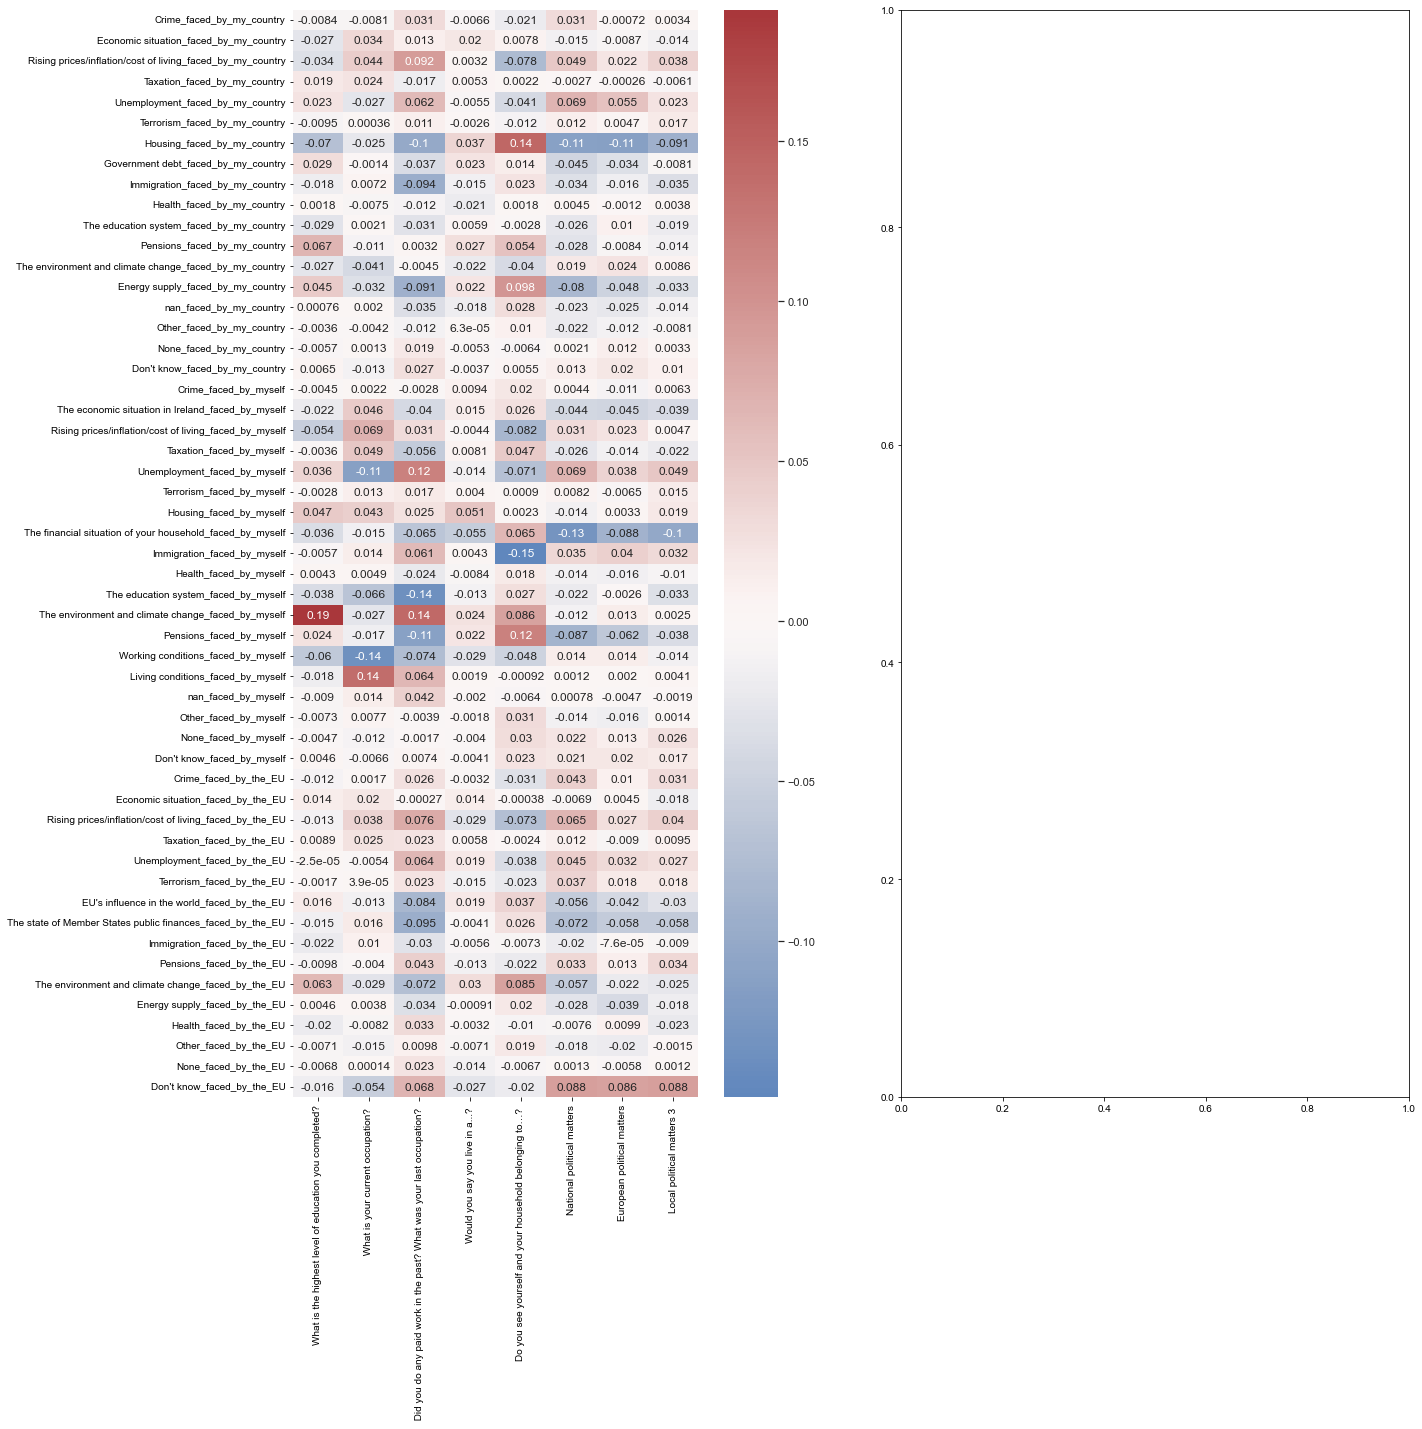

In [9]:
import matplotlib.gridspec as gridspec



fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

text_temp           = np.concatenate((issue_labelling_nested_list[0]["text_suffix"].values, issue_labelling_nested_list[1]["text_suffix"].values, issue_labelling_nested_list[2]["text_suffix"].values))#

demographic_temp    = df_demographics["text"].values

sns.set(rc={'figure.figsize':(11.7,15.27)})
sns.heatmap(general_corr_df_corr, cmap="vlag", annot=True, center=0.00, ax=ax1, xticklabels=demographic_temp, yticklabels=text_temp)


